In [16]:
import os
import sys
import re
from datetime import datetime, timedelta

import sparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from argparse import ArgumentParser

parser = ArgumentParser()
parser.add_argument('--raw_dir', type=str)
parser.add_argument('--output_dir', type=str)
parser.add_argument('--base_res', type=int, default=30, help='X minutes')

# args = parser.parse_args(
#     [
#         '--raw_dir', '../../data/solar_energy_ar/ar-pv-2006',
#         '--output_dir', '../../data/solar_energy_ar',
#     ]
# )
args = parser.parse_args(
    [
        '--raw_dir', '../../data/solar_energy/al-pv-2006',
        '--output_dir', '../../data/solar_energy_10min_debug',
        '--base_res', '10'
    ]
)
args

Namespace(base_res=10, output_dir='../../data/solar_energy_10min_debug', raw_dir='../../data/solar_energy/al-pv-2006')

In [4]:
raw_dir = args.raw_dir
pattern = re.compile(r'Actual\_.*\_[UD]PV\_.*5\_Min\.csv')
filenames = sorted([x for x in os.listdir(raw_dir) if pattern.match(x)])
print(len(filenames))

137


In [5]:
rows = []
for filename in filenames:
    with open(os.path.join(raw_dir, filename), 'r') as f:
        rows.append(len(f.readlines()))

In [6]:
print(min(rows), max(rows))

105121 105121


In [7]:
def parse_file(raw_dir, filename):
    pattern = re.compile(r'Actual\_(-?\d+\.\d+)\_(-?\d+\.\d+).*\_[UD]PV\_.*5\_Min\.csv')
    match = pattern.match(filename)
    lat, long = float(match.group(1)), float(match.group(2))
    lat_long = np.array([lat, long], dtype=np.float32)
    df = pd.read_csv(os.path.join(raw_dir, filename), header=0, delimiter=',')
    power = df['Power(MW)'].values.astype(np.float32)
    return power, lat_long


def collect_all_nodes(raw_dir, filenames):
    parsed = [parse_file(raw_dir, filename) for filename in filenames]
    data = np.stack([x[0] for x in parsed], axis=1)[:, :, np.newaxis] # [T, N, 1]
    locs = np.stack([x[1] for x in parsed], axis=0) # [N, 2]
    return data, locs


data, locs = collect_all_nodes(raw_dir, filenames)

In [8]:
print(data.shape)
print(locs.shape)

(105120, 137, 1)
(137, 2)


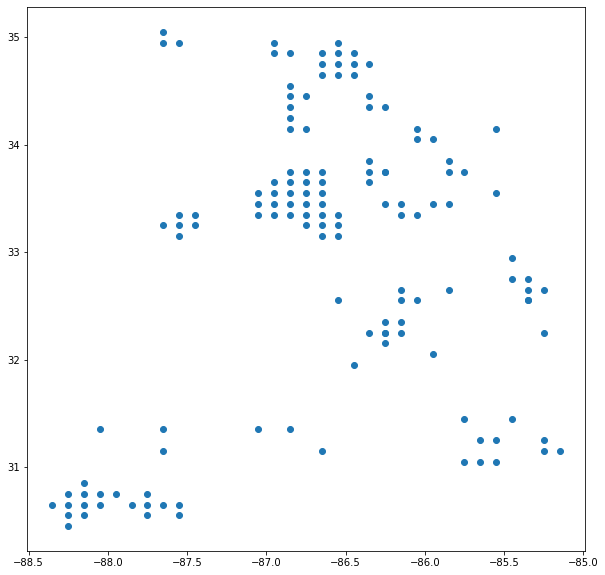

In [17]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(locs[:, 1], locs[:, 0])

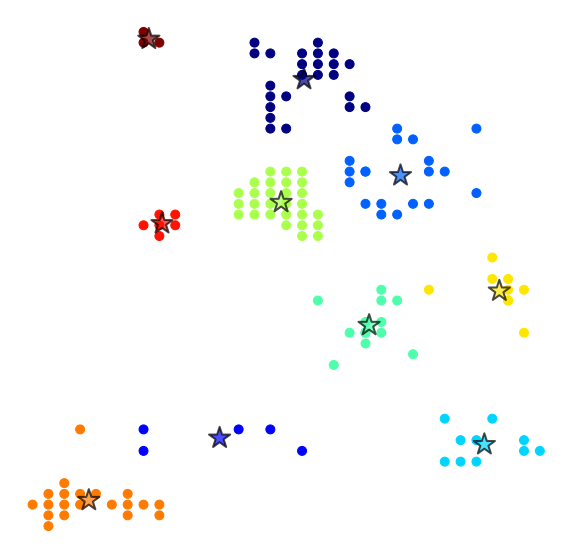

In [40]:
from sklearn.cluster import KMeans

n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(locs)
labels = kmeans.labels_
centers = kmeans.cluster_centers_

fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(locs[:, 1], locs[:, 0], c=labels, cmap='jet', edgecolor='face', alpha=1, s=80)
ax.scatter(centers[:, 1], centers[:, 0], c=np.arange(n_clusters), s=500, cmap='jet', edgecolor='black', alpha=0.7, marker='*', linewidth=2)
ax.set_xticks([])
ax.set_yticks([])
ax.axis('off')
fig.savefig('solarenergy.pdf')

In [11]:
locs_all = np.concatenate([locs, centers], axis=0).astype(np.float32)
node_types = np.concatenate([np.zeros(locs.shape[0]), np.ones(centers.shape[0])]).astype(np.int64)

In [12]:
node_types

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

[[1.         0.         0.         ... 0.         0.         0.        ]
 [0.         1.         0.97093706 ... 0.         0.         0.        ]
 [0.         0.97093706 1.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 1.         0.99265371 0.98536138]
 [0.         0.         0.         ... 0.99265371 1.         0.99265371]
 [0.         0.         0.         ... 0.98536138 0.99265371 1.        ]]
967
(1204, 2) (1204,)


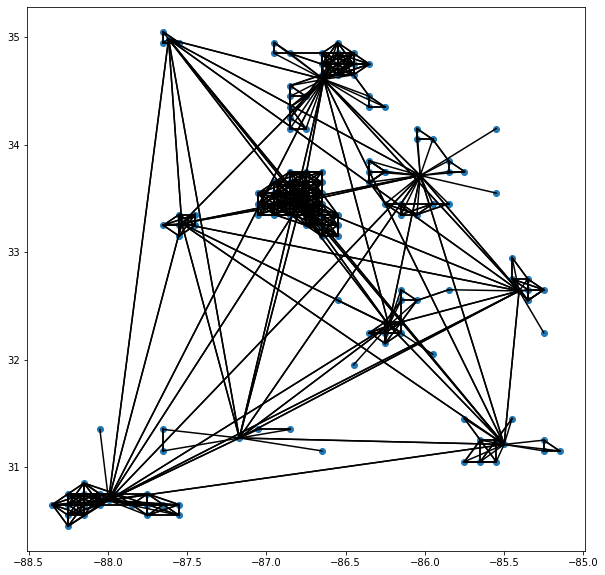

In [15]:
def generate_th_gau_graph(locs_all, node_types, labels, threshold, vis=False):
    locs_small = locs_all[node_types == 0]
    locs_large = locs_all[node_types == 1]
    
    # specify threshold on small nodes
    noden = locs_small.shape[0]
    dist_m = np.zeros((noden, noden))
    for ni in range(noden):
        dist_m[ni, :] = np.linalg.norm(locs_small[ni] - locs_small, axis=1)
    dist_std = dist_m.std()
    dist_normed = np.exp(-(dist_m / dist_std)**2)
    dist_normed[dist_normed <= threshold] = 0
    print(dist_normed)
    print((dist_normed > 0).sum())
    
    # add large nodes, edges between (small, small) and (small, large) should be kept
    noden_all = locs_all.shape[0]
    dist_normed_all = np.zeros((noden_all, noden_all))
    for ni in range(noden_all):
        for nj in range(noden_all):
            if (ni < noden) and (nj < noden):
                dist_normed_all[ni, nj] = dist_normed[ni, nj]
            elif (ni >= noden) and (nj >= noden):
                dist_ni_nj = np.linalg.norm(locs_all[ni] - locs_all[nj])
                dist_normed_all[ni, nj] = np.exp(-(dist_ni_nj / dist_std) ** 2)
            else:
                ni_, nj_ = min(ni, nj), max(ni, nj)
                if labels[ni_] + noden == nj_:
                    dist_ni_nj = np.linalg.norm(locs_all[ni_] - locs_all[nj_])
                    dist_normed_all[ni_, nj_] = np.exp(-(dist_ni_nj / dist_std) ** 2)
                    
    exist_edge_ij = np.where(dist_normed_all > 0)
    edges = np.stack(exist_edge_ij, axis=1)
    edges_weights = dist_normed_all[exist_edge_ij]
    print(edges.shape, edges_weights.shape)
    
    if vis:
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.scatter(locs_all[:, 1], locs_all[:, 0])
        for i, j in edges:
            if i != j:
                li, lj = locs_all[i], locs_all[j]
                ax.plot([li[1], lj[1]], [li[0], lj[0]], 'k-')
    
    return edges, edges_weights

    
edges, edges_weights = generate_th_gau_graph(locs_all, node_types, labels, 0.95, vis=True)

(52560, 137, 1)


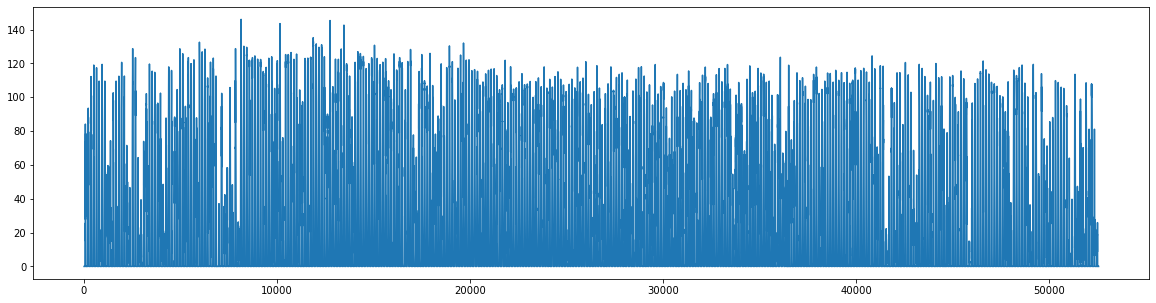

In [13]:
T, N, F = data.shape
data_agg = data.reshape(-1, args.base_res // 5, N, F).sum(axis=1)
print(data_agg.shape)

fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(data_agg[:1000000*24*60//args.base_res, 1, 0])

In [14]:
data_agg_big = []
for ci in range(n_clusters):
    idx = np.where(labels == ci)[0]
    data_agg_big.append(data_agg[:, idx, :].sum(axis=1))
data_agg_big = np.stack(data_agg_big, axis=1)
data_agg_all = np.concatenate([data_agg, data_agg_big], axis=1)
print(data_agg_all.shape)

(52560, 147, 1)


In [15]:
volume_valid_region_borough = data_agg_all
edges_valid_region_borough = {
    'edges': edges,
    'edge_types': edges_weights,
    'node_types': node_types
}
temporal_info = {
    'start': datetime(year=2006, month=1, day=1),
    'delta': timedelta(minutes=args.base_res)
}

if not os.path.exists(args.output_dir):
    os.makedirs(args.output_dir, exist_ok=True)

sparse.save_npz(os.path.join(args.output_dir, 'volume_valid_region_borough.npz'), sparse.COO(volume_valid_region_borough))
np.savez(os.path.join(args.output_dir, 'edges_valid_region_borough.npz'), **edges_valid_region_borough)
np.savez(os.path.join(args.output_dir, 'temporal_info.npz'), **temporal_info)